# Exploring ML models

*by: Pol Reviejo*

The aim of this Notebook is to explore the flexibility of the most popular ML models using a sinthetic dataset of fake data whose group data points cannot be separated linearly.

_______________________________________________________________

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandasql as psql

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

## 1. Creating non real data to test the models

The following function generates a random sample of two independent random variables which have the same distribution given by a $N(\mu,1)$.

In [2]:
def crear_mostra(mitjana,grup):
    
    np.random.seed(1) 
    
    X = np.random.normal(loc=mitjana,scale=1,size=100)
    Y = np.random.normal(loc=mitjana,scale=1,size=100)
    df = pd.DataFrame(
    {
        'x':X,
        'y':Y
    }
    )
    df["Grup"] = grup
    
    return df

We create the sample data:

In [3]:
dades = pd.concat(
    [
    crear_mostra(3,0),
    crear_mostra(9,0),
    crear_mostra(6,1),
    crear_mostra(12,1)
    ]
)

dades

,x,y,Grup
0,4.624345,2.552871,0
1,2.388244,4.224508,0
2,2.471828,3.403492,0
3,1.927031,3.593579,0
4,3.865408,1.905088,0
...,...,...,...
95,12.077340,10.372562,1
96,11.656146,12.602319,1
97,12.043597,12.420282,1
98,11.379999,12.810952,1


Let's visualize the data:

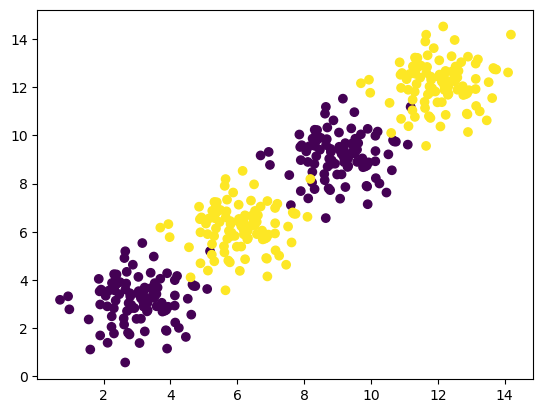

In [4]:
plt.scatter(x=dades["x"],y=dades["y"],c=dades["Grup"])
plt.show()

## 2. Train the models

I create the matrix ```mat_X``` with explanatory variables and the matrix ```mat_Y``` of response variable in order to train the models.

In [5]:
mat_X = np.array( dades.drop(columns=["Grup"]) )
mat_Y = np.array( dades["Grup"] ) 

- Let's start fitting a KNN with $k=4$ to the data

In [6]:
model_knn4 = KNeighborsClassifier(n_neighbors=4)
model_knn4.fit(mat_X,mat_Y)

model_knn4.score(mat_X,mat_Y)

0.98

Let's try a KNN with $k=1$. That's the case of perfect overfitting to the data

In [7]:
model_knn1 = KNeighborsClassifier(n_neighbors=1)
model_knn1.fit(mat_X,mat_Y)

model_knn1.score(mat_X,mat_Y)

1.0

- Let's see how a decision tree with 3 leafs behaves

In [8]:
arbre_3f = DecisionTreeClassifier(max_depth=3,max_features=2)
arbre_3f.fit(mat_X,mat_Y)

arbre_3f.score(mat_X,mat_Y)

0.9525

- Let's see a biggest model: a Random Forest with 5 and 100 trees

In [9]:
rf_5 = RandomForestClassifier(n_estimators=5)
rf_5.fit(mat_X,mat_Y)

rf_5.score(mat_X,mat_Y)

0.9875

In [10]:
rf_100 = RandomForestClassifier(n_estimators=100)
rf_100.fit(mat_X,mat_Y)

rf_100.score(mat_X,mat_Y)

1.0

- Let's see the last tree method a Gradient Boosting. I'll use the basic default hyperparameters.

In [11]:
gbm = GradientBoostingClassifier()
gbm.fit(mat_X, mat_Y)

gbm.score(mat_X,mat_Y)

1.0

- Let's try a Support Vector Machine with a radial basis (or Gaussian) kernel perfoms

In [13]:
svm_rbf = svm.SVC(kernel='rbf',probability=True)  
svm_rbf.fit(mat_X,mat_Y)

svm_rbf.score(mat_X,mat_Y)

0.9825

What if we change the kernel? I'll use polinomial kernel of degree 3

In [14]:
svm_poly = svm.SVC(kernel='poly',degree=3,probability=True)  
svm_poly.fit(mat_X,mat_Y)

svm_poly.score(mat_X,mat_Y)

0.695

- Let's try finally Logistic Regression. Since it's not possible to separate the points with a straight line the model will not perfom good

In [15]:
logreg = LogisticRegression()
logreg.fit(mat_X,mat_Y)

logreg.score(mat_X,mat_Y)

0.505

## 3. See how they can learn patterns from the data

Let's create a dataset of $(x,y)$ coordenates. We will predict each coordenate with the previous models trained

In [16]:
x = range(150)
x = list(x)

gridX= pd.DataFrame(
{
    'x': x,
}
)

coordinates = pd.merge(gridX["x"],gridX["x"],how='cross')
coordinates["x"] = coordinates["x_x"]/10
coordinates["y"] = coordinates["x_y"]/10
coordinates = coordinates.drop(columns=["x_x","x_y"])

In [17]:
def creargrafic(model,titol):
    grid_array = np.array( coordinates )
    probs = model.predict_proba(grid_array)
    
    preds = pd.DataFrame( probs )
    preds["prob"] = preds[0:][0]

    coordinates2 = coordinates.copy()

    preds["id"] = preds.index
    coordinates2["id"] = coordinates.index

    coords = psql.sqldf(
    '''
    SELECT t1.x, t1.y, t2.prob
    FROM coordinates2 AS t1
    LEFT JOIN preds AS t2
        ON t1.id=t2.id
    ''')
    
    plt.xlim(0,15)
    plt.ylim(0,15)
    
    plt.scatter(coords['x'], coords['y'], c=coords['prob'],s=3)
    plt.colorbar(label='Probability predicted')
    plt.scatter(x=dades["x"],y=dades["y"],c=dades["Grup"],s=20)
    plt.title(titol)
    plt.show()

**KNN models**

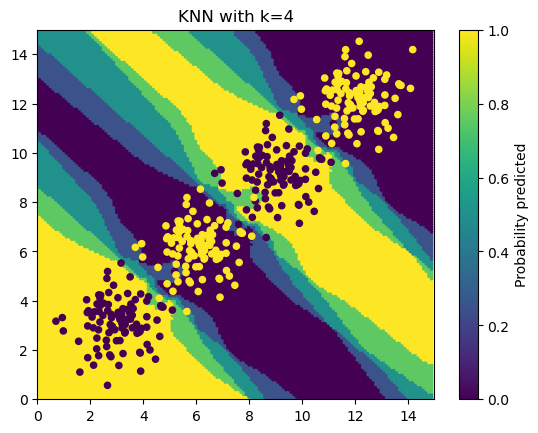

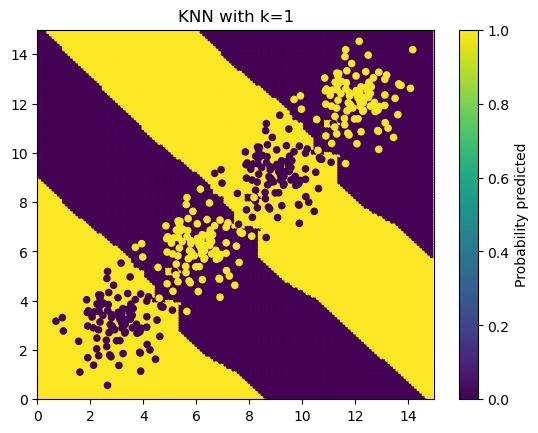

In [18]:
creargrafic(model_knn4,"KNN with k=4")
creargrafic(model_knn1,"KNN with k=1")

**Tree Models**

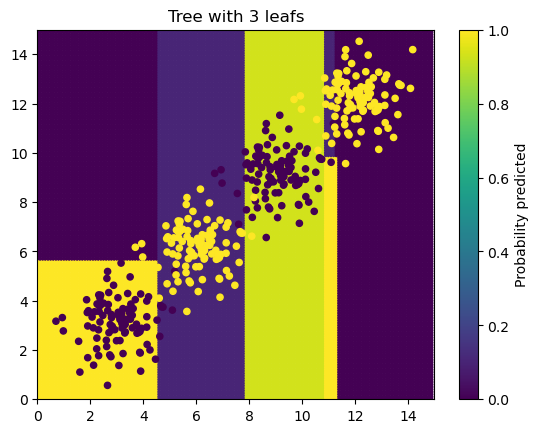

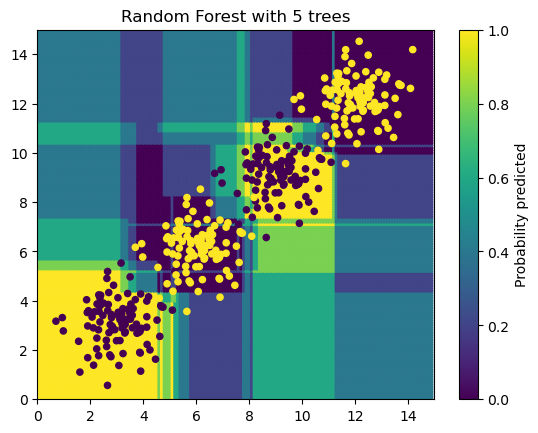

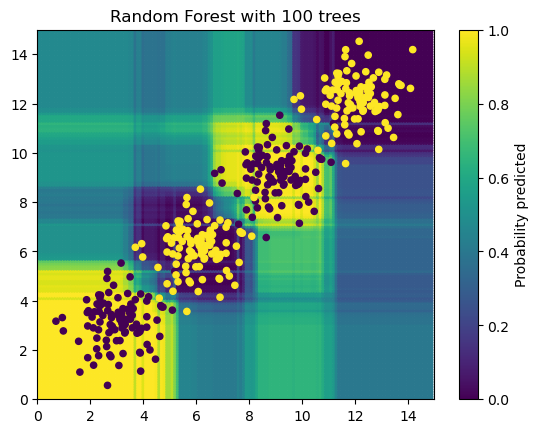

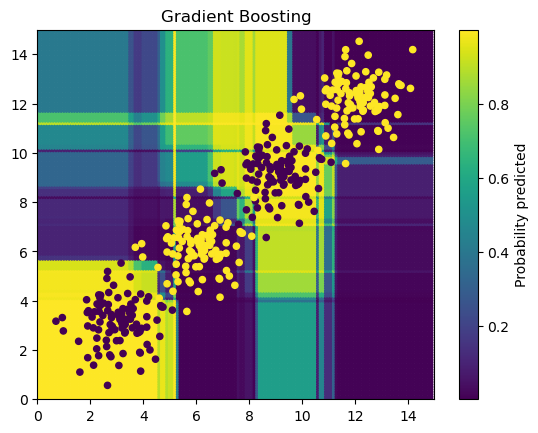

In [19]:
creargrafic(arbre_3f,"Tree with 3 leafs")
creargrafic(rf_5,"Random Forest with 5 trees")
creargrafic(rf_100,"Random Forest with 100 trees")
creargrafic(gbm,"Gradient Boosting")

**Support Vector Machine Models**

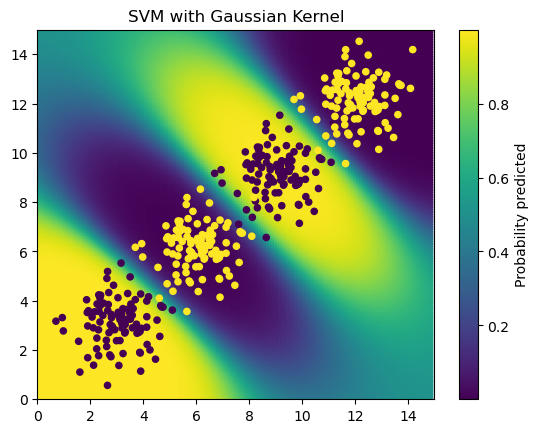

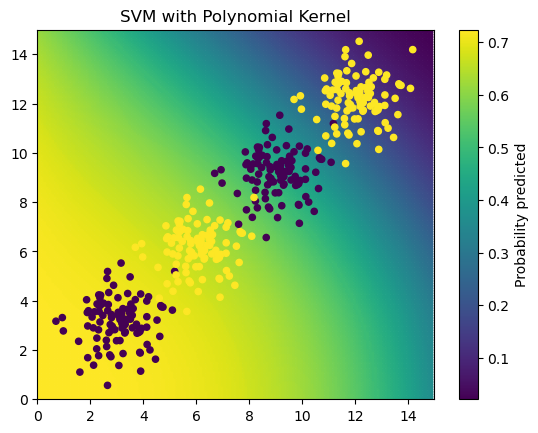

In [20]:
creargrafic(svm_rbf,"SVM with Gaussian Kernel")
creargrafic(svm_poly,"SVM with Polynomial Kernel")

**Logistic Regression**

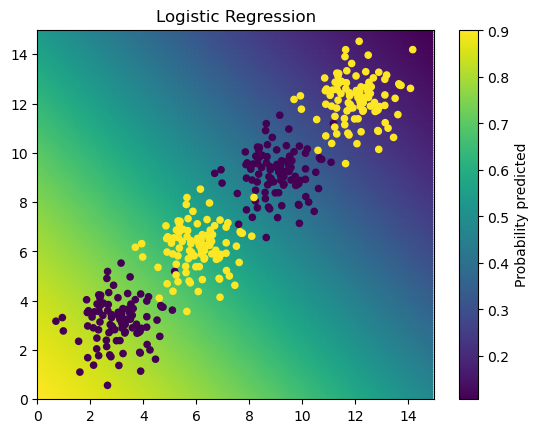

In [21]:
creargrafic(logreg,"Logistic Regression")